In [2]:
import numpy as np
import scipy as sp

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 14, 10
plt.rcParams['lines.linewidth'] = 1.5

font = {'weight' : 'normal',
      'size'   : 15}

plt.rc('font', **font)

In [3]:
def forcing_to_conc(RF_in, 
                   RF_ext = None, 
                   RF_ext_in = False,
                   param_array = np.array([5.396,278.])):
    
   # --- PARAMETERS ---
    #param_array,
        # 1) a = logarithmic forcing efficacy in W/m-2/alog(2). Default = 5.396 W/m^2
        # 2) Cpreind = preindustrial CO2 concentration in ppmv (278.)
    # RF_ext = external radaitive forcing profile which contributes but shouldn't add to the equivalent CO2 concentrations
    # RE_ext_in = boolean, allows user to include or not include the contribution to RF of other (non-anthropogenic) sources
   #---  ----  ---  ---
    
   #Initializing parameters
    a = param_array[...,0]
    C_preind = param_array[...,1]
    if RF_in.ndim == 1:
        rf_dim = 1
        RF_in = RF_in[np.newaxis]
    else:
        rf_dim = RF_in.shape[0]
    
   # Initializing arrays
    # Create array to hold concentration values
    C = np.zeros((RF_in.shape[0],a.size, RF_in.shape[-1]))
    
    # Check inputs are of the same size if external forcing data is also provided
    if RF_ext_in == True:
        if RF_in.shape != RF_ext.shape:
            print 'The inputs RF_in and RF_ext are not of the same shape!'
    elif RF_ext_in == False:
        RF_ext = np.zeros(RF_in.shape)
    
   # Compute required co2 concentration to produce inputted logarithmic forcing
    for i in range(0, RF_in.shape[-1]):
        C[...,i]=np.exp((RF_in[:,np.newaxis,i]-RF_ext[:,np.newaxis,i])/a)*C_preind
    
    return C

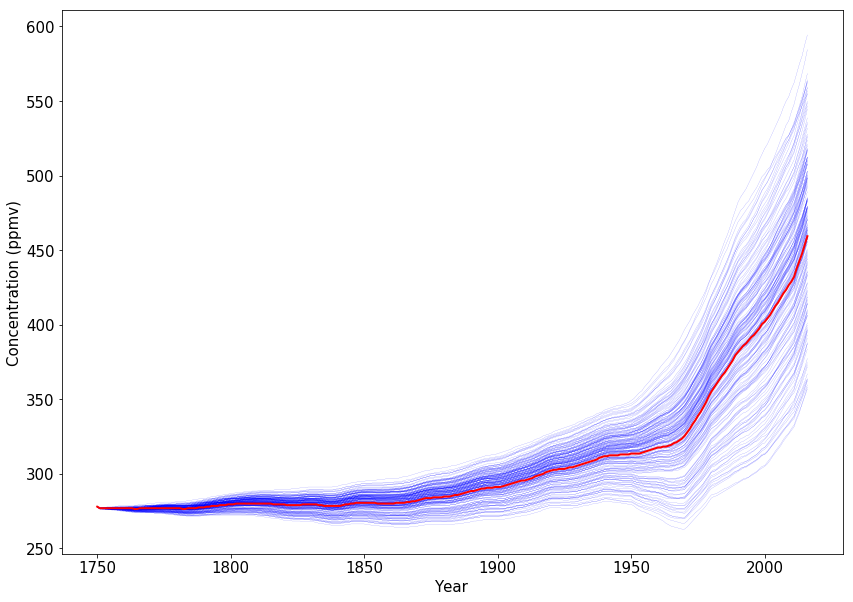

In [4]:
# testing... 

#importing anthro_rf profiles
rf_anthro_piers = np.loadtxt("rf_a_reord.txt")
rf_anthro_piers = rf_anthro_piers.reshape((200,267))

C = forcing_to_conc(rf_anthro_piers)
    
C_median = forcing_to_conc(rf_anthro_piers[90,:])

for i in range(0,199):
    plt.plot(np.arange(1750,2017), C[i,0,:], color = 'blue', linewidth = 0.1)
    
plt.plot(np.arange(1750,2017), C_median[0,0,:], color = 'red', linewidth = 2)

plt.xlabel('Year')
plt.ylabel('Concentration (ppmv)')

In [5]:
from scipy.optimize import root
import scipy.ndimage.filters as filters1

def iirf100_interp_funct(alpha,a,tau,targ_iirf100):
    iirf100_arr = alpha*(np.sum(a*tau*(1.0 - np.exp(-100.0/(tau*alpha)))))
    return iirf100_arr   -  targ_iirf100

def conc_to_emissions_multiparam(co2_conc, T_input, 
                      tstep = 1.0,
                      year_smoothing = 5,
                      param_array = np.array([1000000,381.330,34.7850,4.12370,0.21787,0.22896,0.28454,0.26863,0.471,32.40,0.019,4.165,97.,278.,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
                      ):
    if param_array.ndim < 2:
        param_array = param_array[np.newaxis]
    
   #initialize parameters
    t_const = param_array[...,0:4]
    pool_splits = param_array[...,4:8]
    GtC_2_ppmv = param_array[...,8]
    r0=param_array[...,9]
    rC=param_array[...,10]
    rT=param_array[...,11]
    iirf100_max = param_array[...,12]
    Cpreind = param_array[...,13]
    R_i_in=param_array[...,14:18]
    T_j_in=param_array[...,18:20]
    in_state_other = param_array[...,20]
    
   # PARAMETERS #
    # co2_conc = inputted co2 forcing equivalent concentration profile
    # T_input = inputted temperature profile for given concentration profile
    # t_const = time constants for the different carbon pools
    # pool_splits = how a unit mass of carbon is split between the pools
    # r0 = 100-year integrated airborne fraction (iIRF100) in the initial equilibrium climate for an infinintesimal pulse
    # rC = sensitivity of iIRF100 to cumulative land-ocean carbon uptake, in years/GtC
    # rT = temperature sensitivity of iIRF100 in years/K
    # iirf100_max = maximum value of the iIRF100 we can calculate (saturates at this value if found to be above)
    # Cpreind = pre-industrial CO2 concentration
    # tstep = timestep between interations of code. Default = 1 yr, never tried for other
    # in_state = input state of the different vectors being calcualted
     
   #initialize the carbon pools, emissions, accumulated carbon and iIRF100 vectors. 
    #Give an intial guess of alpha for root function to work from.
    integ_len = co2_conc.shape[-1]
    num_forc = co2_conc.shape[0]
    num_param = co2_conc.shape[1]
    
    C_comp = np.zeros((num_forc, num_param, integ_len, 4))
    E = np.zeros((num_forc, num_param, integ_len))
    C_acc = np.zeros((num_forc, num_param, integ_len))
    iirf100 = np.zeros((num_forc, num_param, integ_len))
    alph_t_start = 0.16
    alph_t = np.zeros((num_forc,num_param))
    
    if num_param < 1:
        t_const = param_array[np.newaxis]
        pool_splits = param_array[np.newaxis]
        GtC_2_ppmv = param_array[np.newaxis]
        r0=param_array[np.newaxis]
        rC=param_array[np.newaxis]
        rT=param_array[np.newaxis]
        iirf100_max = param_array[np.newaxis]
        Cpreind = param_array[np.newaxis]
        R_i_in=param_array[np.newaxis]
        T_j_in=param_array[np.newaxis]
        in_state_other = param_array[np.newaxis]
        C_comp = C_comp[:, np.newaxis, ...]
        E = E[:, np.newaxis, :]
        C_acc = C_acc[:, np.newaxis, :]
        iirf100 = iirf100[:, np.newaxis, :]
        alph_t_start = 0.16
        alph_t = alph_t[:,np.newaxis]
    
   ###---------FIRST TIMESTEP----------
    #set the initial values of key parameters as the in_state values, default = zeros.
    C_comp_pre = R_i_in
    C_pre = np.sum(C_comp_pre, axis = -1) + Cpreind
    T_j_pre = T_j_in
    C_acc_pre = in_state_other

    # Calculate the parametrised iIRF100 and check if it is over the maximum allowed value
    for i in range(0,num_forc):
        for j in range(0, num_param):
            iirf100[i,j,0] = r0[j] + rC[j]*C_acc[i,j,0] + rT[j]*T_input[i,j,0]
            if iirf100[i,j,0] >= iirf100_max[j]:
                iirf100[i,j,0] = iirf100_max[j]
    
    #find the value of alpha
    for i in range(0,num_forc):
        for j in range(0,num_param):
            alph_t[i,j] = (root(iirf100_interp_funct,alph_t_start,args=(pool_splits[j,:],t_const[j,:],iirf100[i,j,0])))['x']
    
            #compute the carbon in each pool
            C_comp[i,j,0,:] = C_comp_pre[j,:]*np.exp((-tstep)/(alph_t[i,j]*t_const[j,:]))
    
            #compute the emissions required to give change in CO2 concentration
            E[i,j,0] = (co2_conc[i,j,0] - np.sum(C_comp[i,j,0,:],-1) - C_pre[j]) / (alph_t[i,j]*np.sum(pool_splits[j,:]*t_const[j,:]*(1-np.exp((-tstep)/(alph_t[i,j]*t_const[j,:]))))*GtC_2_ppmv[j])
    
            #recompute the distribution of carbon in each pool for better estimation of emissions in next timestep
            C_comp[i,j,0,:] = C_comp[i,j,0,:] + alph_t[i,j]*pool_splits[j,:]*t_const[j,:]*E[i,j,0]*GtC_2_ppmv[j]*(1-np.exp((-tstep)/(alph_t[i,j]*t_const[j,:])))
    
            #calculate the accumulated carbon in the land and oceans
            C_acc[i,j,0] =  C_acc_pre[j] + E[i,j,0]*tstep - ((co2_conc[i,j,0]-C_pre[j])/GtC_2_ppmv[j])
    
   ###----------REST OF RUN-------------
    for i in range(0,num_forc):
        for j in range(0,num_param):
            for k in range(1, integ_len):
                #estimate the value of iIRF100, given the temperature and accumulated carbon in previous timestep
                iirf100[i,j,k] = r0[j] + rC[j]*C_acc[i,j,k-1] + rT[j]*T_input[i,j,k-1]
                if iirf100[i,j,k] > iirf100_max[j]:
                    iirf100[i,j,k] = iirf100_max[j]
        
                #calculate the value of alpha using scipys root finder
                alph_t[i,j] = (root(iirf100_interp_funct,alph_t[i,j],args=(pool_splits[j,:],t_const[j,:],iirf100[i,j,k])))['x']
        
                #compute the distribution of carbon between the pools
                C_comp[i,j,k,:] = C_comp[i,j,k-1,:]*np.exp((-tstep)/(alph_t[i,j]*t_const[j,:]))
        
                #calculate the emissions required in this year to cause change in CO2 concentration
                E[i,j,k] = (co2_conc[i,j,k] - np.sum(C_comp[i,j,k,:],-1) - Cpreind[j]) / (alph_t[i,j]*np.sum(pool_splits[j,:]*t_const[j,:]*(1-np.exp((-tstep)/(alph_t[i,j]*t_const[j,:]))))*GtC_2_ppmv[j])
        
                #recalculate the distribution of carbon in each pool for better estimation in next timestep
                C_comp[i,j,k,:] = C_comp[i,j,k,:] + \
                    alph_t[i,j]*pool_splits[j,:]*t_const[j,:]*E[i,j,k]*GtC_2_ppmv[j]*(1-np.exp((-tstep)/(alph_t[i,j]*t_const[j,:])))
        
                #calculate the accumulated carbon in the land and sea
                C_acc[i,j,k] =  C_acc[i,j,k-1] + E[i,j,k]*tstep - ((co2_conc[i,j,k]-co2_conc[i,j,k-1])/GtC_2_ppmv[j])
        
   ###----------------------------------
   
    # We apply a gaussian filter to smooth the resulting curve
    E_smooth = np.zeros((num_forc,num_param,integ_len))
    for i in range(0,num_forc):
        for j in range(0,num_param):
            E_smooth[i,j,:] = filters1.gaussian_filter1d(E[i,j,:], year_smoothing)
    
    return E, E_smooth

In [6]:
from forward import fair_scm as fair_model_multi_param
C1, T = fair_model_multi_param(other_rf=rf_anthro_piers)
T = T[:,np.newaxis,:]

---------- Run time was 0 minutes and 12 seconds ----------


In [7]:
E,E_smooth = conc_to_emissions_multiparam(C,T)

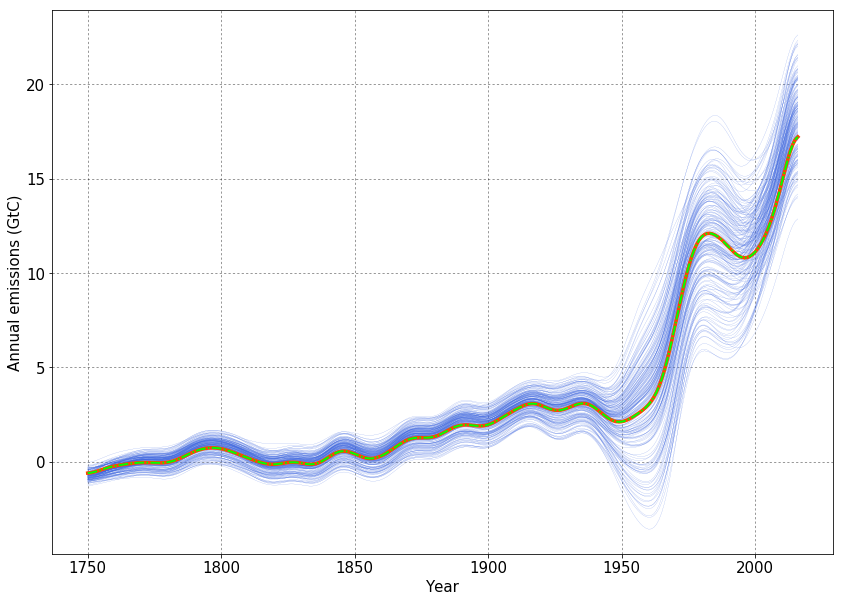

In [8]:
for i in range(0,E_smooth.shape[0]):
    plt.plot(np.arange(1750,2017), E_smooth[i,0,:], color = 'royalblue', linewidth = 0.13)
    
plt.plot(np.arange(1750,2017), E_smooth[90,0,:], color = 'orangered', linewidth = 3.5)

import fair_inverse_revised

E90,E90_smooth = fair_inverse_revised.conc_to_emissions(C[90,0,:],T[90,0,:])
plt.plot(np.arange(1750,2017), E90_smooth, color = 'lime', linewidth = 2, linestyle = '-.')

plt.xlabel('Year')
plt.ylabel('Annual emissions (GtC)')
plt.grid(True, color = 'black', linestyle = ':', alpha = 0.5)

In [9]:
param_array_conc_to_emms = np.array([1000000,381.330,34.7850,4.12370,0.05,0.236489403703,0.3,0.413510596297,0.471,39.1193644809,0.0152,3.332,97.,279.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
param_array_forc_to_conc = np.array([5.352,279.51])
input_params_T=np.array([0.33,0.41,1.6,2.75,239.0,4.1,0.05,0.236489403703,0.3,0.413510596297,1000000,394.4,36.54,4.304,39.1193644809,0.0152,3.332,3.71,279.51,2.123,97.0])

C2 = forcing_to_conc(rf_anthro_piers, param_array = param_array_forc_to_conc)
C_no, T2 = fair_model_multi_param(other_rf = rf_anthro_piers, input_params = input_params_T)
T2 = T2[:,np.newaxis,:]
E2,E2_smooth = conc_to_emissions_multiparam(C2, T2, param_array = param_array_conc_to_emms)

---------- Run time was 0 minutes and 13 seconds ----------


660.389240826


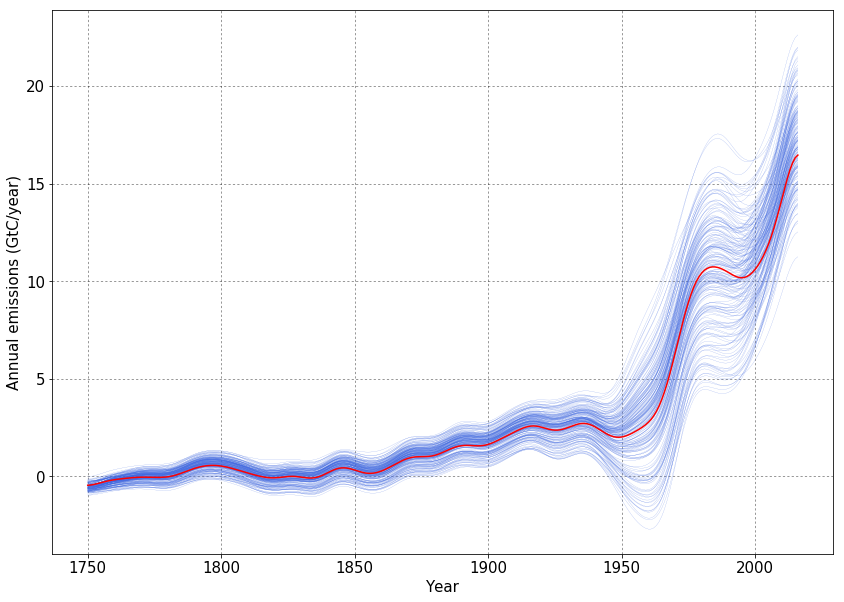

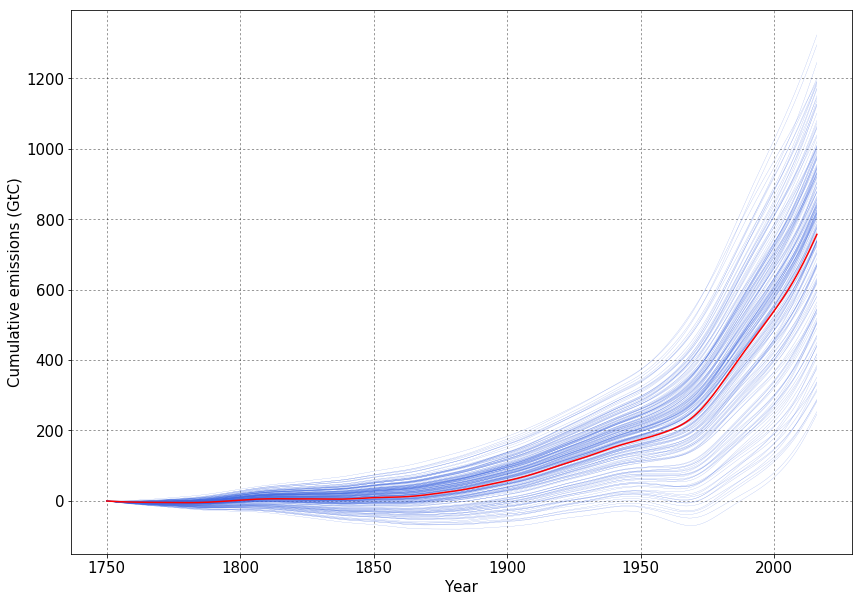

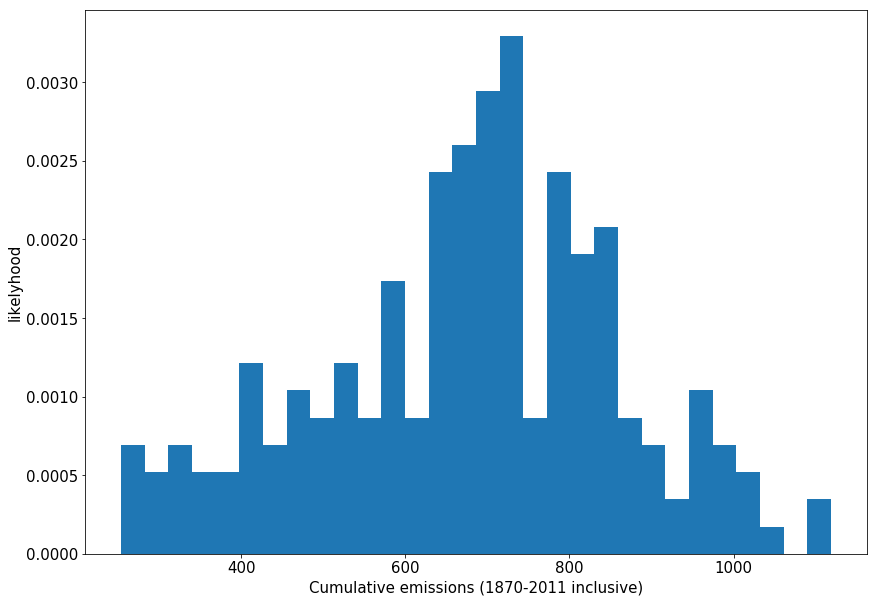

In [12]:
for i in range(0,E2_smooth.shape[0]):
    plt.plot(np.arange(1750,2017), E2_smooth[i,0,:], color = 'royalblue', linewidth = 0.13)

plt.plot(np.arange(1750,2017), E2_smooth[90,0,:], color = 'red')
plt.grid(True, color = 'black', linestyle = ':', alpha = 0.5)
plt.xlabel('Year')
plt.ylabel('Annual emissions (GtC/year)')

cumulative_totals = np.cumsum(E2_smooth[...,0,:], axis = -1)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
for i in range(0,cumulative_totals.shape[0]):
    ax2.plot(np.arange(1750,2017), cumulative_totals[i,:], color = 'royalblue', linewidth = 0.13)
ax2.plot(np.arange(1750,2017), cumulative_totals[90,:], color = 'red')
ax2.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax2.set_xlabel('Year')
ax2.set_ylabel('Cumulative emissions (GtC)')

cumulative_totals1 = cumulative_totals[:,1870-1750:] - cumulative_totals[:,1870-1750,np.newaxis]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(cumulative_totals1[:,2011-1870].tolist(), bins = 30, normed = True)
ax1.set_xlabel('Cumulative emissions (1870-2011 inclusive)')
ax1.set_ylabel('likelyhood')

cum_again = np.cumsum(E2_smooth[90,0,:][1870-1750:])
print cum_again[2011-1870]

In [159]:
rf_t_selection = np.loadtxt('jenko_profiles.txt')
rf_t_selection = rf_t_selection.reshape((10000,267))

param_array_conc_to_emms = np.array([1000000,381.330,34.7850,4.12370,0.05,0.236489403703,0.3,0.413510596297,0.471,39.1193644809,0.0152,3.332,97.,279.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
param_array_forc_to_conc = np.array([5.352,279.51])
input_params_T=np.array([0.33,0.41,1.6,2.75,239.0,4.1,0.05,0.236489403703,0.3,0.413510596297,1000000,394.4,36.54,4.304,39.1193644809,0.0152,3.332,3.71,279.51,2.123,97.0])

C_10000 = forcing_to_conc(rf_t_selection, param_array = param_array_forc_to_conc)
C_no, T_10000 = fair_model_multi_param(other_rf = rf_t_selection, input_params = input_params_T)
T_10000 = T_10000[:,np.newaxis,:]
E_10000,E_10000_smooth = conc_to_emissions_multiparam(C_10000, T_10000, param_array = param_array_conc_to_emms)

---------- Run time was 10 minutes and 48 seconds ----------


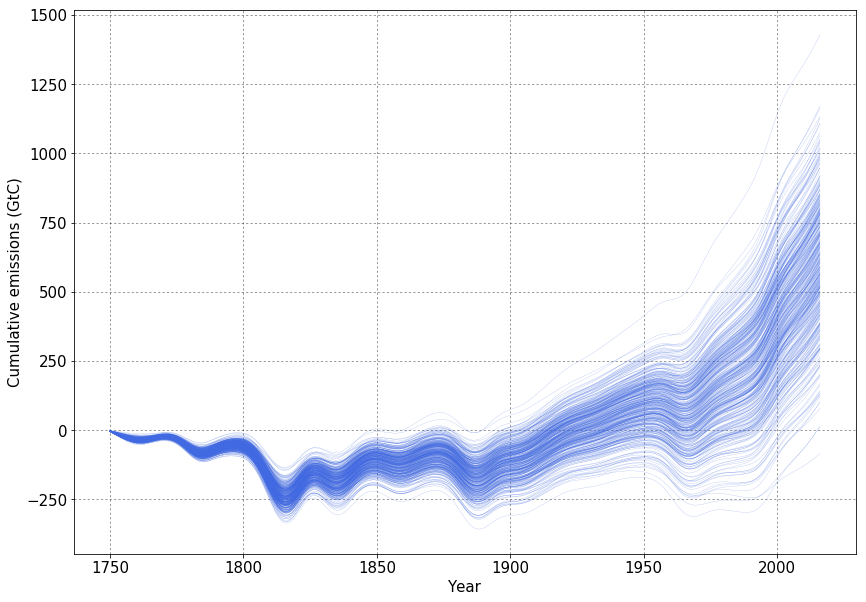

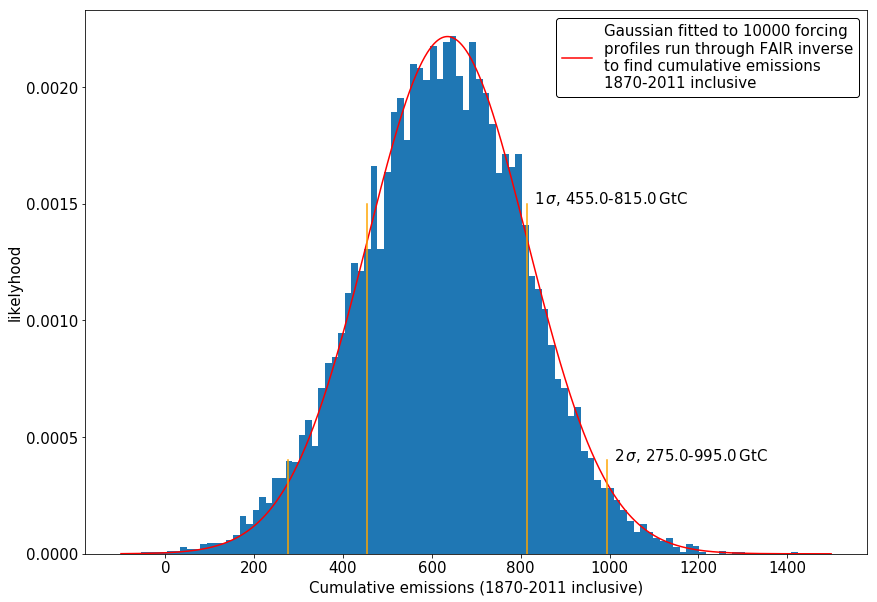

In [10]:
emms_selection = np.loadtxt('emissions_10000.txt')
emms_selection = emms_selection.reshape((10000,1,267))

cumulative_totals_10000 = np.cumsum(emms_selection[...,0,:], axis = -1)

fig = plt.figure()
ax2 = fig.add_subplot(111)
for i in range(0,cumulative_totals_10000.shape[0],25):
    ax2.plot(np.arange(1750,2017), cumulative_totals_10000[i,:], color = 'royalblue', linewidth = 0.13)
ax2.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax2.set_xlabel('Year')
ax2.set_ylabel('Cumulative emissions (GtC)')

cumulative_totals_10000_1 = cumulative_totals_10000[:,1870-1750:] - cumulative_totals_10000[:,1870-1750,np.newaxis]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(cumulative_totals_10000_1[:,2011-1870].tolist(), bins = 100, normed = True)
ax1.set_xlabel('Cumulative emissions (1870-2011 inclusive)')
ax1.set_ylabel('likelyhood')

x = np.arange(-100.,1500.,1.)
mu, sigma = 635., 180.
gaussian_pdf = (1 / (np.sqrt(2*np.pi*sigma**2))) * np.exp(-(((x-mu)**2)/(2*sigma**2)))
ax1.plot(x, gaussian_pdf, color='red', label='Gaussian fitted to 10000 forcing\nprofiles run through FAIR inverse\nto find cumulative emissions\n1870-2011 inclusive')

ax1.legend(loc = 'best', framealpha = 1, edgecolor = 'black')
n=2
ax1.plot(np.ones(2)*(mu - n*sigma), np.array([0,0.0004]), color = 'orange')
ax1.plot(np.ones(2)*(mu + n*sigma), np.array([0,0.0004]), color = 'orange')
ax1.text(1010, 0.0004, '2$\,\sigma$, %s-%s$\,$GtC' %((mu - n*sigma),(mu + n*sigma)))
n=1
ax1.plot(np.ones(2)*(mu - n*sigma), np.array([0,0.0015]), color = 'orange')
ax1.plot(np.ones(2)*(mu + n*sigma), np.array([0,0.0015]), color = 'orange')
ax1.text(830, 0.0015, '1$\,\sigma$, %s-%s$\,$GtC' %((mu - n*sigma),(mu + n*sigma)))
